# Business Problem - Portfolio Optimiser

With the contributions and efforts of mankind to technology, the world is in the stage of "Fourth Industrial Revolution - Digitalisation", where digital transformation is occuring in every part of the globe. Not only are F&B or Transportation sector getting digitalised, the whole macroeconomic landscape of Finance and Banking is getting revolutionised as well. The digital transformation in Finance and Banking sector brought about value-added consumer services, efficacy in risk management and efficiency in investing, contributing to the birth of FinTech.

In the light of recent developments in FinTech, WealthisHealth Pte. Ltd. was founded to provide financial and asset management solutions to clients by utilising technology to further improve on risk mitigation and customer-service excellence. The a technology team is formed to design a solution that involves provision of investment plans that are managed effectively and efficiently using technological tools such as Optimisation. Using Optimisation in Python Programming, WealthisHealth Pte. Ltd. can efficiently compute out the optimal way to allocate the wealth of clients to different assets to maximise returns based on the client's risk tolerance and investment preference.

This project will be the basis for building a prototype program that will automate and run the Portfolio Optimiser, for the asset manager to use and provide effective wealth solution for the clients.

# Key Assumptions

1. Bond prices, ratings and details are compiled into an excel document as it is assumed that the firm obtained the data by outsourcing from another company.


2. Stock return data are downloaded from Yahoo Finance. Since different assets are formed during different time periods, to keep the data consistent, the program will be utilising historical data for all assets/stocks from 30 Jun 2022 to 1 Jan 2015.


3. Portfolio styles, proportions and level of required returns have been pre-measured and computed by finance analysts. It is in form of a dictionary and will be defined later.


4. To quantify the overall risk of bonds, an in-house designed scoring metrics is used to assign each bond a score based on their Bond Rating. Overall risk of bonds in portfolio will be computed by taking the total sum of all proportion of different scores from types of bonds invested. <i>For example, if 50% of total bonds is invested into a bond rating giving score of 5, another half into bond rating giving score of 2, total risk score of bonds will be 0.5 * 5 + 0.5 * 2 = 3.5.</i>


5. Bond interest (coupon) payments is assumed to be paid out promptly as it is a debt obligation.


6. All stock returns data will be stored in form of csv (comma-separated values) while bond datas are stored in xlsx (excel) format for ease of automation and handling.


7. Portfolios are re-adjusted on a monthly basis with more data coming in each month.

In [1]:
#import necessary packages and libraries
import glob
import os
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from math import sqrt
from rsome import ro
from rsome import grb_solver as solver

In [2]:
#automates and read all csv files containing the stock/asset prices inside the current folder
dfs = {f.stem: pd.read_csv(f) for f in pathlib.Path().glob('*.csv')}
dfs

{'AAPL':             Date        Open        High         Low       Close   Adj Close  \
 0     2015-01-02   27.847500   27.860001   26.837500   27.332500   24.644016   
 1     2015-01-05   27.072500   27.162500   26.352501   26.562500   23.949759   
 2     2015-01-06   26.635000   26.857500   26.157499   26.565001   23.952013   
 3     2015-01-07   26.799999   27.049999   26.674999   26.937500   24.287874   
 4     2015-01-08   27.307501   28.037500   27.174999   27.972500   25.221066   
 ...          ...         ...         ...         ...         ...         ...   
 1881  2022-06-23  136.820007  138.589996  135.630005  138.270004  138.078201   
 1882  2022-06-24  139.899994  141.910004  139.770004  141.660004  141.463501   
 1883  2022-06-27  142.699997  143.490005  140.970001  141.660004  141.463501   
 1884  2022-06-28  142.130005  143.419998  137.320007  137.440002  137.249359   
 1885  2022-06-29  137.460007  140.669998  136.669998  139.229996  139.036865   
 
          Volume  

In [3]:
#To create a dataframe with dates for stocks/assets data to be appended into the master stock list later.
master_stock_list = dfs[list(dfs)[0]]['Date']
master_stock_list = pd.DataFrame(master_stock_list)
stock_price_table = pd.DataFrame()

In [4]:
#each of the stocks/asset prices to be assigned to a newly created variable corresponding to their ticker symbol.
for stock in dfs.keys():
    myVars = locals()
    myVars.__setitem__(stock, dfs[stock])
    dfs[stock]['Change'] = dfs[stock]['Close'].pct_change()
    master_stock_list[stock] = (dfs[stock]['Change'])
    stock_price_table[stock] = dfs[stock]['Close']
    if stock in master_stock_list.columns:
        print('{0} stock returns appended into master list.'.format(stock))
    else:
        print('{0} stock returns failed into append to master list.'.format(stock))

AAPL stock returns appended into master list.
BNDX stock returns appended into master list.
EMB stock returns appended into master list.
GLD stock returns appended into master list.
IJR stock returns appended into master list.
IYK stock returns appended into master list.
KO stock returns appended into master list.
MCD stock returns appended into master list.
QQQ stock returns appended into master list.
SMH stock returns appended into master list.
VDC stock returns appended into master list.
VOO stock returns appended into master list.
XLE stock returns appended into master list.
XLF stock returns appended into master list.
XLK stock returns appended into master list.


In [5]:
master_stock_list.dropna(inplace=True) #drop any NA rows
master_stock_list.head(15)

,Date,AAPL,BNDX,EMB,GLD,IJR,IYK,KO,MCD,QQQ,SMH,VDC,VOO,XLE,XLF,XLK
1,2015-01-05,-0.028172,-0.000375,-0.006403,0.015077,-0.015280,-0.011233,0.000000,-0.011044,-0.014669,-0.017801,-0.008194,-0.017569,-0.041368,-0.021027,-0.015265
2,2015-01-06,0.000094,0.002250,-0.003130,0.011399,-0.016683,-0.005729,0.007594,0.001843,-0.013408,-0.023543,-0.000810,-0.009833,-0.014690,-0.015283,-0.012057
3,2015-01-07,0.014022,-0.000748,0.012560,-0.005891,0.010399,0.016894,0.012482,0.017424,0.012891,0.013012,0.016456,0.012495,0.002130,0.010487,0.008468
4,2015-01-08,0.038422,-0.000374,0.004287,-0.004209,0.017514,0.016230,0.012096,0.003723,0.019140,0.024934,0.015392,0.017568,0.022450,0.014944,0.021981
5,2015-01-09,0.001073,-0.000562,-0.000636,0.011385,-0.009760,-0.008127,-0.011032,-0.012187,-0.006583,-0.002949,-0.007697,-0.008421,-0.007925,-0.013497,-0.003142
6,2015-01-12,-0.024641,0.002249,-0.005816,0.011086,-0.003405,-0.004668,-0.009063,-0.002146,-0.010427,-0.012754,-0.004037,-0.007424,-0.028811,-0.008292,-0.011636
7,2015-01-13,0.008879,0.000935,0.003199,-0.003374,0.004136,-0.002202,-0.000234,-0.001935,-0.000295,-0.005617,-0.000397,-0.002637,-0.007956,-0.003344,-0.000736
8,2015-01-14,-0.003811,0.002429,0.007563,-0.001608,-0.004835,-0.002590,-0.001642,-0.013896,-0.005516,-0.003766,-0.002703,-0.005881,0.003126,-0.014262,-0.005646
9,2015-01-15,-0.027140,-0.004659,0.001356,0.025176,-0.015744,-0.005290,-0.004229,-0.001748,-0.012975,0.005481,0.002232,-0.009335,-0.012737,-0.012341,-0.012836
10,2015-01-16,-0.007770,0.005804,0.000722,0.013064,0.016179,0.010153,0.003539,0.001204,0.011741,0.008083,0.007477,0.012381,0.032528,0.012064,0.009752


In [6]:
days = len(master_stock_list['Date']) #get the no. of days from the stock data loaded (will be used for optimiser later)

In [7]:
stock_price_table.head(10) #to show the prices of stocks in dataframe table.

,AAPL,BNDX,EMB,GLD,IJR,IYK,KO,MCD,QQQ,SMH,VDC,VOO,XLE,XLF,XLK
0,27.332500,53.349998,109.320000,114.080002,56.610001,104.160004,42.139999,93.260002,102.940002,54.490002,124.480003,188.399994,79.529999,20.089357,41.270000
1,26.562500,53.330002,108.620003,115.800003,55.744999,102.989998,42.139999,92.230003,101.430000,53.520000,123.459999,185.089996,76.239998,19.666937,40.639999
2,26.565001,53.450001,108.279999,117.120003,54.814999,102.400002,42.459999,92.400002,100.070000,52.259998,123.360001,183.270004,75.120003,19.366369,40.150002
3,26.937500,53.410000,109.639999,116.430000,55.384998,104.129997,42.990002,94.010002,101.360001,52.939999,125.389999,185.559998,75.279999,19.569456,40.490002
4,27.972500,53.389999,110.110001,115.940002,56.355000,105.820000,43.509998,94.360001,103.300003,54.259998,127.320000,188.820007,76.970001,19.861900,41.380001
5,28.002501,53.360001,110.040001,117.260002,55.805000,104.959999,43.029999,93.209999,102.620003,54.099998,126.339996,187.229996,76.360001,19.593826,41.250000
6,27.312500,53.480000,109.400002,118.559998,55.615002,104.470001,42.639999,93.010002,101.550003,53.410000,125.830002,185.839996,74.160004,19.431356,40.770000
7,27.555000,53.529999,109.750000,118.160004,55.845001,104.239998,42.630001,92.830002,101.519997,53.110001,125.779999,185.350006,73.570000,19.366369,40.740002
8,27.450001,53.660000,110.580002,117.970001,55.575001,103.970001,42.560001,91.540001,100.959999,52.910000,125.440002,184.259995,73.800003,19.090172,40.509998
9,26.705000,53.410000,110.730003,120.940002,54.700001,103.419998,42.380001,91.379997,99.650002,53.200001,125.720001,182.539993,72.860001,18.854589,39.990002


In [8]:
bonds = pd.read_excel('bonds_data.xlsx')
bonds

,Bonds,Maturity,Annual Interest Rate,Limit,Ratings
0,1-Year Corporate Bond,1,0.035,100000,BBB
1,5-Year Corporate Bond,5,0.062,50000,BB
2,5-Year Corporate Bond,5,0.050,50000,BBB
3,5-Year International Bond,5,0.030,200000,A
4,5-Year Mortgage Bond,5,0.060,10000,A
5,10-Year Treasury Bond,10,0.010,1000000,AAA
6,20-Year Treasury Bond,20,0.015,1000000,AAA


In [9]:
#Assign each column of bond details to different variables for further data processing later.
bond_type, bond_maturity, bond_interest, bond_limit, bond_ratings = bonds.iloc[:,0], bonds.iloc[:,1], bonds.iloc[:,2], bonds.iloc[:,3], bonds.iloc[:,4]

# Functions

The following contains the coded functions necessary for the Portfolio Optimiser.

1. <b>annualised_ret</b> function is used to compute annualised returns using with Geometric Mean.

2. <b>rating </b> function will be used to assign different scores using the firm's score metrics on quantifying the riskiness of bonds.

In [10]:
def annualised_ret(returns_data,periods_per_year=365):
    returns = np.prod(returns_data+1)
    return (returns**(periods_per_year/len(returns_data))-1)

In [11]:
def rating(bond_rating,bond_score):
    return_rating = 0
    for rating, score in bond_score.items():
        if bond_rating == rating:
            return_rating = score
        else:
            continue
    return return_rating

# Data preparation (Stocks/Assets)

In [12]:
#form a n x 1 matrix and prepare list of stocks for further programming purposes. (will be used for optimiser later)
stock_list = master_stock_list.drop(columns={'Date'},axis=0)
stocks_ = stock_list.columns
stocks_ = np.array([stocks_]).transpose()
stocks_

array([['AAPL'],
       ['BNDX'],
       ['EMB'],
       ['GLD'],
       ['IJR'],
       ['IYK'],
       ['KO'],
       ['MCD'],
       ['QQQ'],
       ['SMH'],
       ['VDC'],
       ['VOO'],
       ['XLE'],
       ['XLF'],
       ['XLK']], dtype=object)

In [13]:
#form a n x 1 matrix and prepare the corresponding annualised returns of each stock/asset. (will be used for optimiser later)
stock_returns = stock_list.apply(annualised_ret,axis=0)
stock_returns = np.array([stock_returns]).transpose()
stock_returns

array([[ 0.36739343],
       [-0.01684914],
       [-0.04831968],
       [ 0.07987764],
       [ 0.10241394],
       [ 0.12835421],
       [ 0.0786194 ],
       [ 0.20370018],
       [ 0.21688632],
       [ 0.29871792],
       [ 0.07938744],
       [ 0.12805109],
       [-0.00956723],
       [ 0.09378883],
       [ 0.24628287]])

In [14]:
stock_corr_table = stock_list.corr()
stock_corr_table

,AAPL,BNDX,EMB,GLD,IJR,IYK,KO,MCD,QQQ,SMH,VDC,VOO,XLE,XLF,XLK
AAPL,1.000000,0.053901,0.379246,-0.004397,0.556413,0.600716,0.374614,0.428257,0.828010,0.695026,0.530978,0.748748,0.375481,0.527110,0.851218
BNDX,0.053901,1.000000,0.366895,0.224028,0.024260,0.119987,0.103462,0.091699,0.082836,0.062486,0.119745,0.070268,-0.020457,-0.061775,0.078112
EMB,0.379246,0.366895,1.000000,0.197236,0.505090,0.528013,0.402863,0.447662,0.503025,0.476295,0.442706,0.559748,0.459768,0.461286,0.512397
GLD,-0.004397,0.224028,0.197236,1.000000,-0.026098,0.051425,0.047650,0.009672,-0.001455,-0.002431,0.051576,-0.012351,0.020053,-0.132700,-0.002867
IJR,0.556413,0.024260,0.505090,-0.026098,1.000000,0.741620,0.515961,0.529672,0.716726,0.708019,0.647996,0.850547,0.716130,0.852735,0.731870
IYK,0.600716,0.119987,0.528013,0.051425,0.741620,1.000000,0.744540,0.632677,0.744486,0.644231,0.910513,0.857790,0.562728,0.733266,0.751658
KO,0.374614,0.103462,0.402863,0.047650,0.515961,0.744540,1.000000,0.517738,0.471820,0.382172,0.787382,0.623293,0.432824,0.566167,0.497682
MCD,0.428257,0.091699,0.447662,0.009672,0.529672,0.632677,0.517738,1.000000,0.534519,0.456619,0.583063,0.641249,0.433448,0.585380,0.558869
QQQ,0.828010,0.082836,0.503025,-0.001455,0.716726,0.744486,0.471820,0.534519,1.000000,0.869786,0.662251,0.923606,0.474761,0.672180,0.976666
SMH,0.695026,0.062486,0.476295,-0.002431,0.708019,0.644231,0.382172,0.456619,0.869786,1.000000,0.541414,0.819224,0.478049,0.628974,0.880125


# Visualisation Aid Station

This section is designed for the portfolio manager to be able to visualise different data for the assets/stocks. This can be for aid in exploring information about portfolio or to assist in brainstorming for future tuning or adjustments that should be recommended to the programmer by the portfolio manager.

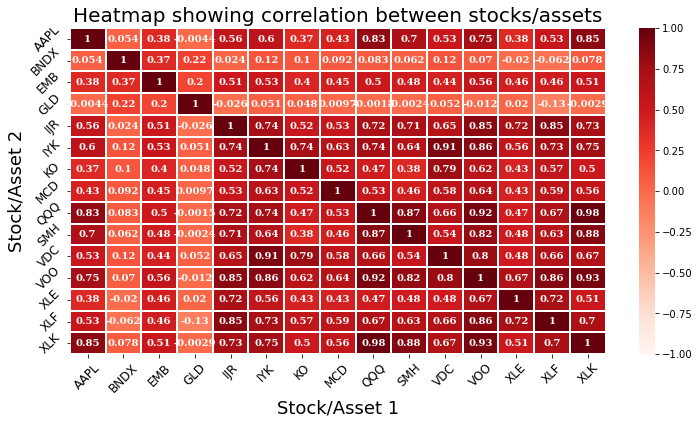

In [15]:
figure = plt.figure(figsize=(12,6))
ax1 = figure.add_subplot(111)
sns.heatmap(stock_corr_table,
            vmin=-1,
            vmax=1,
            cmap='Reds',
            annot=True,
            annot_kws={
                'fontsize': 10,
                'fontweight':'bold',
                'fontfamily':'serif'
                
            },
            linewidth=2,
            ax=ax1)

#configuring the labels of a heat map
plt.title('Heatmap showing correlation between stocks/assets',fontsize=20)
plt.xlabel('Stock/Asset 1',fontsize=18)
plt.ylabel('Stock/Asset 2',fontsize=18)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(rotation=45,fontsize=12)
plt.show()

# Data preparation (Bonds)

In [16]:
bond_rating_score = {                      #bond rating metrics formulated by firm. Scoring is based on S&P Bond Rating.

    'AAA' : 1,
    'AA' : 2,
    'A' : 3,
    'BBB' : 4, 
    'BB' : 5,
    'CCC' : 6,
    'CC' : 7,
    'C' : 8,
    'D' : 9
}

In [17]:
#match and look up the bond rating of each type of bond and allocate its score based on the scoring metrics.
bond_rating_score = pd.DataFrame(bond_rating_score.items(), columns=['Ratings','Score'])
bond_score = pd.merge(bonds,bond_rating_score,on='Ratings',how='inner')
bond_score

,Bonds,Maturity,Annual Interest Rate,Limit,Ratings,Score
0,1-Year Corporate Bond,1,0.035,100000,BBB,4
1,5-Year Corporate Bond,5,0.050,50000,BBB,4
2,5-Year Corporate Bond,5,0.062,50000,BB,5
3,5-Year International Bond,5,0.030,200000,A,3
4,5-Year Mortgage Bond,5,0.060,10000,A,3
5,10-Year Treasury Bond,10,0.010,1000000,AAA,1
6,20-Year Treasury Bond,20,0.015,1000000,AAA,1


In [18]:
#form a m x 1 matrix of corresponding scores of bonds to be prepared for usage in Optimiser.
bond_score = np.array([bond_score['Score']])
bond_score = bond_score.transpose()
bond_score

array([[4],
       [4],
       [5],
       [3],
       [3],
       [1],
       [1]], dtype=int64)

In [19]:
#form a m x 1 matrix of corresponding interest rates of bonds to be prepared for usage in Optimiser.
bond_interest = np.array([bond_interest]).transpose()
bond_interest

array([[0.035],
       [0.062],
       [0.05 ],
       [0.03 ],
       [0.06 ],
       [0.01 ],
       [0.015]])

# Portfolio Styles

The firm has designed and prepared different styles of portfolio with different allocation of stocks and bonds. Different portfolio styles have a specified rate of return for the client. Normally, the portfolio on the conservative end with lower risk in general will contain higher proportion of wealth allocated to bonds while riskier portfolios will contain higher proportion of wealth allocated to stocks.

For each client and their preferred portfolio style and required return, we can use the Portfolio Optimiser to optimise the allocation of portfolio that minimises the risk, yet ensures that the required return is met.

In [20]:
portfolio_style = {                                      #Portfolio styles developed by the firm.
    "Title":["Stocks","Bonds","Returns"],
    "High-Roller": [0.8, 0.2, 0.175],
    "Aggressive": [0.65, 0.35, 0.15],
    "Balanced" : [0.5, 0.5, 0.125],
    "Conservative" : [0.3, 0.7, 0.1],
    "Gradual Growth" : [0.1, 0.9, 0.075],
}

# Selection

In [21]:
#User can do selection for inputs to prepare for the Portfolio Optimiser.

while True:
    print('Let us begin the portfolio selection process...')
    
    Capital = input('Amount to invest: ') #User will first key in the amount of wealth that the client wishes to invest.
    
    #2ndly, user will key in the portfolio style that is agreed on by the client after discussion with Portfolio manager.
    desired_port = input('Portfolio Style: ')
    if desired_port in portfolio_style and float(Capital) >= 0:
        break
    else:
        #prints error message and start the input function again.
        print('Error. Please make sure you indicate the correct portfolio and the amount of Capital is not 0')
        
while True:
    
    #3rdly, user will key in the maxmimum bond default score that the aggregate bond default scores cannot exceed.
    bond_default = input('Maximum bond default score: ')
    if float(bond_default) >= 1.0:
        break
    else:
        #prints error message and start the input function again.
        print('Error. Please make sure the maximum bond default score is at least 1.')

while True:
    
    #4th, user will key in the maximum allowed proportion for each stock/asset for stricter diversification.
    max_stock_prop = input('Maximum proportion for each stock/asset to ensure diversification: ')
    if float(max_stock_prop) >= 0.0 and float(max_stock_prop) <= 1:
        break
    else:
        #prints error message and start the input function again.
        print('Error. Please make sure the proportion is not zero.')

stock_proportion = portfolio_style[desired_port][0]
bond_proportion = portfolio_style[desired_port][1]
required_return = portfolio_style[desired_port][2]
print('\nProportions: {1} Stocks, {2} Bond. Required return: {3} \nEach Stock/Asset Proportion: {4}.'
      .format(desired_port, stock_proportion, bond_proportion, required_return, max_stock_prop))

Let us begin the portfolio selection process...
Amount to invest: 1000000
Portfolio Style: Balanced
Maximum bond default score: 5
Maximum proportion for each stock/asset to ensure diversification: 0.25

Proportions: 0.5 Stocks, 0.5 Bond. Required return: 0.125 
Each Stock/Asset Proportion: 0.25.


In [22]:
#preparation for optimiser
RetTable = np.array(master_stock_list.iloc[:,1:])
RetMean = np.mean(RetTable, axis = 0)# Compute the mean of each stock and their covariance
RetCov = np.matmul((RetTable - RetMean).T , (RetTable - RetMean)) /(RetTable.shape[0]-1)
Flag_posdef = np.all(np.linalg.eigvals(RetCov) > 0) # Check wheter the covariance matrix is positive definite
print(Flag_posdef)

True


# Optimiser

In [23]:
Capital = float(Capital)
bond_default = float(bond_default)
required_return = float(required_return)
max_stock_prop = float(max_stock_prop)
cvarlevel = 0.1 # CVaR confidence level
T = days
N = len(stocks_)

In [24]:
model = ro.Model('Portfolio Optimiser')
#X[stock] : Amount of weights to put into each stock
x = model.dvar(len(stocks_))

#Y[bond] : Amount of weight to put into each bond
y = model.dvar(len(bonds['Bonds']))

#p : No. of days
p = model.dvar(T)

#s : duality variable
s = model.dvar()

#Objective
model.min(cvarlevel*T*s + sum(p))

#Constraints for stocks/assets 
model.st(s + p[t] >= -1/(cvarlevel*T)*sum(RetTable[t,i]*x[i] for i in range(N)) for t in range(T))

model.st(sum(x) == stock_proportion)
model.st(x >= 0)
model.st(x <= stock_proportion*max_stock_prop)

#Constraints for bonds
for bond in range(len(bonds['Bonds'])):
    model.st(Capital*y[bond] <= bond_limit[bond])

model.st(sum(y) == bond_proportion)
    
model.st(y@bond_score <= bond_default)
model.st(y >= 0)
model.st(p >= 0)

#Constraint for total required return
model.st(x@stock_returns + y@bond_interest >= required_return)

#Solve
model.solve(solver)

port_stock_returns = x.get()@stock_returns
port_bond_returns = y.get()@bond_interest
portfolio_returns = port_stock_returns + port_bond_returns
print(x.get())
print(y.get())
print(model.get())
print('\n\nReturns from stocks: {0}\nReturns from bonds: {1}\nTotal Portfolio Returns: {2}'
      .format(port_stock_returns, port_bond_returns, portfolio_returns))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-12
Being solved by Gurobi...
Solution status: 2
Running time: 0.0988s
[0.125      0.01746047 0.         0.125      0.         0.03082346
 0.         0.125      0.         0.07671608 0.         0.
 0.         0.         0.        ]
[0.1  0.05 0.05 0.2  0.01 0.   0.09]
0.00861795974122278


Returns from stocks: [0.10795]
Returns from bonds: [0.01705]
Total Portfolio Returns: [0.125]


In [25]:
bond_allocation = Capital*y.get()
stock_allocation = Capital*x.get()

final_stock_table = pd.DataFrame(np.array(stock_list.columns))
final_stock_table['Stock allocation'] = stock_allocation
final_stock_table #visualising the allocation into stocks in table form.

,0,Stock allocation
0,AAPL,125000.000000
1,BNDX,17460.467653
2,EMB,0.000000
3,GLD,125000.000000
4,IJR,0.000000
5,IYK,30823.457008
6,KO,0.000000
7,MCD,125000.000000
8,QQQ,0.000000
9,SMH,76716.075339


In [26]:
final_bond_table = bonds.copy()
final_bond_table['Bond allocation'] = bond_allocation
final_bond_table #visualising the allocation of wealth into bonds in table form.

,Bonds,Maturity,Annual Interest Rate,Limit,Ratings,Bond allocation
0,1-Year Corporate Bond,1,0.035,100000,BBB,100000.0
1,5-Year Corporate Bond,5,0.062,50000,BB,50000.0
2,5-Year Corporate Bond,5,0.050,50000,BBB,50000.0
3,5-Year International Bond,5,0.030,200000,A,200000.0
4,5-Year Mortgage Bond,5,0.060,10000,A,10000.0
5,10-Year Treasury Bond,10,0.010,1000000,AAA,0.0
6,20-Year Treasury Bond,20,0.015,1000000,AAA,90000.0


# Limitations

There are a number of limitations that I have encountered throughout this journey:

1. There may be no optimal solutions if I were to set too high of a returns. Based on an asset manager or expert's advice, they may require the required return to be higher than what the optimiser produce.


2. The adequacy of bond riskiness may not be adequate as a simple bond-risk metrics was used to give scores in accordance to bond ratings. The overall bond scores may not be truly reflective of the amount of default risk taken by the client.


3. This program can be further improved to automate .excel files of different bond datas. In this case, very limited number of bonds are used and it is assumed that the bonds data are pre-processed and pre-prepared via outsourcing.


4. This program cannot be used to set coerrelation coefficient nor covariance as the constraint as it can cause the equation and function to become bi-linear in nature and the optimiser will hence not be able to run. Hence, I added in an additional feature of diversification by having limitation of proportion of each asset/stock class as a constraint. Hopefully any future enhancement to the program can be programmed to provide a better alternative for diversification for the portfolio rather than only minimising C-VAR, yet getting higher returns.

5. The Optimisation model assigns the weight of different assets are allocated based on calculation of annualised returns and conditional variance at risk, where are all calculated based on historical data of each asset. As the famous saying, "past performance is not indicative of future results". Over-reliance on past results to reap future benefits may cause unexpected results and hence, to improve the model, future indicators or forward-looking mechanism should be added to improve the model.

# Reflection

Along this journey of developing this Portfolio Optimiser, I came across many challenges...

<b>1. Complications in Optimisation.</b>

I initially tried to maximise Sharpe ratio as the objective function, where (x decision variables matrix multiply by annualised stock returns + y decision variables matrix multiply by bond interests), divided by (x matrix multiply by annualised volatility).

However, I realised that the Optimiser did not work as objective function of Sharpe ratio as there is x and y decision variables being divided by x decision variables, which forms a bi-linear equation, causing optimiser to not be able to work. From this experience, I realise optimisation in practical situations are not as straight-forward and easy as it seems.

I tried to do diversification by setting inequality constraint of correlation coefficient. As calculation of coefficient coefficient involves creating a matrix of proportion - proportion of stock table, the optimiser did not run and work as well. Hence to design the best alternative for ensure diversification, I included a cosntraint of ensuring that the user can set a maximum proportion for each stock/asset to force the optimiser not to put too much wealth into one stock. 


<b>2. Rigorous design in constraints and objective functions.</b>

This is also complicated by the rigorous plannings and design of every single constraint. Not only must data and variables be prepared properly before putting into the functions, we have to ensure that the equations makes practical sense as well. As I launched the Optimiser with objective function of minimising Conditional Variance-at-Risk (VaR). I also wanted to make this programme practical by automating the process and ensure that the code is neat. Therefore I spent a great amount of time trying to automate and ensure the code runs well even if I add on the number of stocks or use different time periods of stock returns.


<b>3. Creativity plays an important role in problem-solving.</b>

It is important to have critical-thinking and innovation behind each optimisation problem. Depending on context, different scenario calls for different ways of optimisation. Furthermore, I noticed that there may be different adjustments that the portfolio manager would wish to adjust as well. Therefore on the selection, I provided multiple inputs to allow the portfolio manager to adjust the different inputs, to allow a certain degree of flexibility.



# 